# Take constrained output for WG3 and put into impulse response form

- Use constrained FaIR setup from 056 and 057
- apply Zeb's conversion
- test

In [1]:
import fair
import json
import sys
import os
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
from multiprocessing import Pool

from ar6.utils.h5 import *
from ar6.forcing.aerosol import aerocom_n, ghan
from ar6.twolayermodel import TwoLayerModel

from netCDF4 import Dataset
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d

from tqdm.notebook import tqdm

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [2]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [3]:
NINETY_TO_ONESIGMA = st.norm.ppf(0.95)

## Climate model parameters

### load unconstrained

In [4]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')

# accepted ensemble
accept_inds = np.loadtxt('../data_output_large/fair-samples/accept_inds.csv', dtype=int)

### apply the constraint and overwrite unconstrained

In [5]:
accept_inds

array([   838,    949,   1242, ..., 999362, 999380, 999843])

In [6]:
geoff_sample_df.loc[accept_inds]

,q4x,lamg,cmix,cdeep,gamma_2l,eff
838,9.273214,-1.635251,6.148327,150.303560,0.743663,1.415621
949,8.976294,-1.187633,6.454781,99.281930,0.717200,1.891549
1242,7.607466,-1.621618,9.979336,211.420597,0.643690,1.070795
2110,8.007978,-0.659745,6.944094,55.568035,0.823893,2.067918
2509,9.112583,-1.829337,9.725970,215.461523,0.665151,0.889553
...,...,...,...,...,...,...
999021,8.859442,-1.200989,8.527159,78.088790,0.739437,1.715458
999359,7.638968,-1.265169,8.066919,55.466701,0.515077,0.929718
999362,9.862818,-1.153942,6.061896,162.547532,0.777108,2.955820
999380,8.710426,-0.980681,4.870043,189.856296,0.670366,2.769520


In [7]:
# ozone
ozone_feedback = ozone_feedback[accept_inds]
beta_ch4 = beta_ch4[accept_inds]
beta_n2o = beta_n2o[accept_inds]
beta_ods = beta_ods[accept_inds]
beta_co = beta_co[accept_inds]
beta_voc = beta_voc[accept_inds]
beta_nox = beta_nox[accept_inds]

# carbon cycle
pre_ind_co2 = pre_ind_co2[accept_inds]
r0 = r0[accept_inds]
rC = rC[accept_inds]
rT = rT[accept_inds]

# aerosol
beta_so2 = beta_so2[accept_inds]
beta_bc = beta_bc[accept_inds]
beta_oc = beta_oc[accept_inds]
beta_nh3 = beta_nh3[accept_inds]
beta = beta[accept_inds]
aci_coeffs = aci_coeffs[accept_inds]

# forcing
scale_normals = scale_normals[accept_inds]
trend_solar = trend_solar[accept_inds]

# climate response
geoff_sample_df = geoff_sample_df.loc[accept_inds]
f2x = f2x[accept_inds]
ecs = ecs[accept_inds]
tcr = tcr[accept_inds]

In [8]:
with open('../data_input/tunings/cmip6_twolayer_tuning_params.json', 'r') as filehandle:
    cmip6_models = json.load(filehandle)

f2x_median = np.median(f2x)
ecs_median = np.median(ecs)
tcr_median = np.median(tcr)

cmix_mean = cmip6_models['cmix']['mean']['EBM-epsilon']
cdeep_mean = cmip6_models['cdeep']['mean']['EBM-epsilon']
eff_mean = cmip6_models['eff']['mean']['EBM-epsilon']

lamg_median = f2x_median/ecs_median
kappa_median = -(f2x_median/ecs_median - f2x_median/tcr_median)
gamma_2l_median = kappa_median/eff_mean

lamg = -geoff_sample_df['lamg'].values
eff = geoff_sample_df['eff'].values
gamma_2l = geoff_sample_df['gamma_2l'].values
cdeep = geoff_sample_df['cdeep'].values
cmix = geoff_sample_df['cmix'].values

(array([182., 802., 929., 426., 102.,  51.,  44.,  23.,   4.,   2.]),
 array([0.01965245, 0.40516315, 0.79067386, 1.17618456, 1.56169526,
        1.94720597, 2.33271667, 2.71822737, 3.10373808, 3.48924878,
        3.87475949]),
 <a list of 10 Patch objects>)

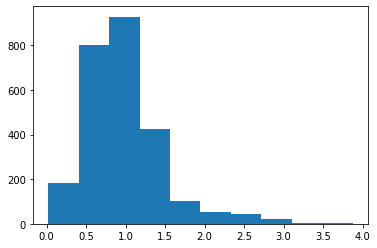

In [9]:
kappa = f2x/tcr - f2x/ecs
# kappa = efficacy * eta
pl.hist(kappa)

## Convert Geoffroy to impulse-response

- this is shamelessly copied from Zeb, but indpendence from pint and scmdata makes things run 10x faster
- TODO: move under `twolayermodel`

In [10]:
def _calculate_geoffroy_helper_parameters(
    cmix, cdeep, lambda0, efficacy, eta
):

    b_pt1 = (lambda0 + efficacy * eta) / cmix
    b_pt2 = eta / cdeep
    b = b_pt1 + b_pt2
    b_star = b_pt1 - b_pt2
    delta = b ** 2 - (4 * lambda0 * eta) / (cmix * cdeep)

    taucoeff = cmix * cdeep / (2 * lambda0 * eta)
    d1 = taucoeff * (b - delta ** 0.5)
    d2 = taucoeff * (b + delta ** 0.5)

    phicoeff = cmix / (2 * efficacy * eta)
    phi1 = phicoeff * (b_star - delta ** 0.5)
    phi2 = phicoeff * (b_star + delta ** 0.5)

    adenom = cmix * (phi2 - phi1)
    a1 = d1 * phi2 * lambda0 / adenom
    a2 = -d2 * phi1 * lambda0 / adenom

    qdenom = cmix * (phi2 - phi1)
    q1 = d1 * phi2 / qdenom
    q2 = -d2 * phi1 / qdenom

    out = {
        "d1": d1,
        "d2": d2,
        "q1": q1,
        "q2": q2,
        "efficacy": efficacy,
    }
    return out

In [11]:
gh = _calculate_geoffroy_helper_parameters(
    cmix_mean, cdeep_mean, lamg_median, eff_mean, gamma_2l_median
)

In [12]:
gh

{'d1': 3.5308295377301486,
 'd2': 269.0801804312028,
 'q1': 0.4294935738439283,
 'q2': 0.30820845525783996,
 'efficacy': 1.3412508139190835}

In [13]:
bccesm11 = _calculate_geoffroy_helper_parameters(
    8.4, 56, 1.28, 1.27, 0.59, 
)

In [14]:
bccesm11

{'d1': 4.071963898885451,
 'd2': 152.9682903384027,
 'q1': 0.47664923825844835,
 'q2': 0.3046007617415519,
 'efficacy': 1.27}

## Get impulse response parameters for WG3 ensemble

In [15]:
output = []
for i in range(len(accept_inds)):
    gh = _calculate_geoffroy_helper_parameters(cmix[i], cdeep[i], lamg[i], eff[i], gamma_2l[i])
    output.append([accept_inds[i], cmix[i], cdeep[i], lamg[i], gamma_2l[i], kappa[i], gh['d1'], gh['d2'], gh['q1'], gh['q2'], eff[i], ecs[i], tcr[i], f2x[i]])
    
df = pd.DataFrame(output, columns=[
    'id',
    'C (W yr / m^2 / K)',
    'C_d (W yr / m^2 / K)',
    'alpha (W / m^2 / K)',
    'eta (dimensionless)',
    'kappa (W / m^2 / K)',
    'd1 (yr)',
    'd2 (yr)',
    'q1 (K / (W / m^2))',
    'q2 (K / (W / m^2))',
    'efficacy (dimensionless)',
    'ecs (K)',
    'tcr (K)',
    'erf2xCO2 (W / m^2)',
])

In [16]:
df.median()

id                          476677.000000
C (W yr / m^2 / K)               8.382267
C_d (W yr / m^2 / K)           127.910629
alpha (W / m^2 / K)              1.356152
eta (dimensionless)              0.675074
kappa (W / m^2 / K)              0.898957
d1 (yr)                          3.666146
d2 (yr)                        330.816694
q1 (K / (W / m^2))               0.427703
q2 (K / (W / m^2))               0.295590
efficacy (dimensionless)         1.341314
ecs (K)                          2.947199
tcr (K)                          1.748124
erf2xCO2 (W / m^2)               3.995107
dtype: float64

In [17]:
q_df = df.quantile((0.50, 0.05, 0.95))

In [18]:
df.set_index('id', inplace=True)
df

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),erf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
838,6.148327,150.303560,1.635251,0.743663,1.052745,2.277165,333.711512,0.368715,0.242812,1.415621,2.295143,1.396258,3.753136
949,6.454781,99.281930,1.187633,0.717200,1.356619,2.512246,299.479556,0.385376,0.456634,1.891549,3.548605,1.656456,4.214441
1242,9.979336,211.420597,1.621618,0.643690,0.689260,4.301393,469.909682,0.429315,0.187353,1.070795,2.619564,1.838233,4.247932
2110,6.944094,55.568035,0.659745,0.823893,1.703743,2.847585,249.297186,0.397298,1.118440,2.067918,5.171358,1.443535,3.411777
2509,9.725970,215.461523,1.829337,0.665151,0.591687,4.005043,430.012991,0.410521,0.136125,0.889553,2.117491,1.599987,3.873605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999021,8.527159,78.088790,1.200989,0.739437,1.268474,3.395113,220.850457,0.391369,0.441278,1.715458,2.918967,1.419599,3.505647
999359,8.066919,55.466701,1.265169,0.515077,0.478877,4.569800,150.252585,0.559462,0.230946,0.929718,3.298057,2.392482,4.172598
999362,6.061896,162.547532,1.153942,0.777108,2.296991,1.746805,629.041422,0.286551,0.580044,2.955820,3.404068,1.138271,3.928097


In [19]:
q_df['id'] = ['median', '5th percentile', '95th percentile']
q_df.set_index('id', inplace=True)
q_df

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),erf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
median,8.382267,127.910629,1.356152,0.675074,0.898957,3.666146,330.816694,0.427703,0.295590,1.341314,2.947199,1.748124,3.995107
5th percentile,5.554378,58.844320,0.739832,0.472577,0.356575,1.883238,158.787708,0.311337,0.099180,0.642046,1.984713,1.249245,3.528160
95th percentile,10.267962,321.765669,2.004354,0.913127,1.919911,5.338714,836.443748,0.591310,0.913816,2.475461,5.347164,2.429792,4.463919


In [20]:
full_df=q_df.append(df)
full_df

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),erf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
median,8.382267,127.910629,1.356152,0.675074,0.898957,3.666146,330.816694,0.427703,0.295590,1.341314,2.947199,1.748124,3.995107
5th percentile,5.554378,58.844320,0.739832,0.472577,0.356575,1.883238,158.787708,0.311337,0.099180,0.642046,1.984713,1.249245,3.528160
95th percentile,10.267962,321.765669,2.004354,0.913127,1.919911,5.338714,836.443748,0.591310,0.913816,2.475461,5.347164,2.429792,4.463919
838,6.148327,150.303560,1.635251,0.743663,1.052745,2.277165,333.711512,0.368715,0.242812,1.415621,2.295143,1.396258,3.753136
949,6.454781,99.281930,1.187633,0.717200,1.356619,2.512246,299.479556,0.385376,0.456634,1.891549,3.548605,1.656456,4.214441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999021,8.527159,78.088790,1.200989,0.739437,1.268474,3.395113,220.850457,0.391369,0.441278,1.715458,2.918967,1.419599,3.505647
999359,8.066919,55.466701,1.265169,0.515077,0.478877,4.569800,150.252585,0.559462,0.230946,0.929718,3.298057,2.392482,4.172598
999362,6.061896,162.547532,1.153942,0.777108,2.296991,1.746805,629.041422,0.286551,0.580044,2.955820,3.404068,1.138271,3.928097


In [21]:
full_df.to_csv('../data_output_large/fair-samples/impulse_response.csv')